## Temporal Difference Learning (Q-learning algorithm / SARSA)

In [29]:
import gym
from gym import wrappers

# from __future__ import annotations

from collections import defaultdict
from typing import Tuple

import numpy as np
from IPython import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### The blackjack gym

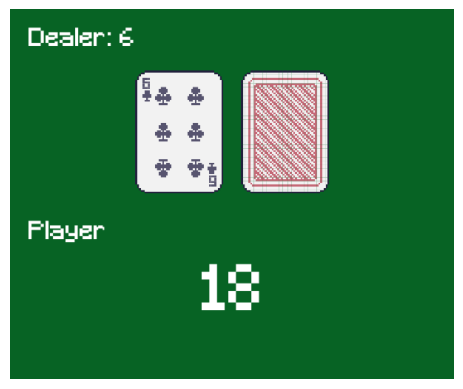

In [12]:
# env = gym.make("CartPole-v1",render_mode='rgb_array')

env = gym.make('Blackjack-v1',render_mode='rgb_array')

for episode in range(10):
    state = env.reset()
    done = False
    
    while not done:
        img = plt.imshow(env.render())
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        state = observation

env.close()

## Naive quick solution

Here we present a quick solution to the problem and illustrate the importance of good coding tecnique in RL

In [15]:

def q_learning(env, num_episodes, alpha=0.1, gamma=0.5, epsilon=0.1):
    q_table = np.zeros((env.observation_space[0].n, env.observation_space[1].n, 2, env.action_space.n))
    rewards = []
    episode_rewards = []
    episodes = []
    training_error = []

    for episode in range(num_episodes):
        state, done = env.reset()
        state = state[0], state[1], int(state[2])
        episode_reward = 0
        episode_len = 0

        while not done:
            
            
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, done, _, info = env.step(action)
            next_state = next_state[0], next_state[1], int(next_state[2])
            
            temporal_diff = alpha * (reward + gamma * np.max(q_table[next_state]) - q_table[state][action])
    
            q_table[state][action] += temporal_diff
            
            episode_reward += reward
            episode_len += 1
            state = next_state
            training_error.append(temporal_diff)

            
        rewards.append(reward)
        episode_rewards.append(episode_reward)
        episodes.append(episode_len)

    return rewards, q_table, episodes

def run_multiple_experiments(num_experiments, num_episodes, alpha=0.3, gamma=0.9, epsilon=0.3):
    experiment_rewards = []
    experiment_episodes =[]

    for _ in range(num_experiments):
        env = gym.make('Blackjack-v1')
        env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)
        rewards, q_table, episodes = q_learning(env, num_episodes, alpha, gamma, epsilon)

        experiment_rewards.append(rewards)
        experiment_episodes.append(episodes)
        
    experiment_rewards =np.array(experiment_rewards)
    R_t =  np.mean(experiment_rewards.T,axis=1) 
    
    experiment_episodes = np.array(experiment_episodes)
    experiment_episodes =  np.mean(experiment_episodes.T,axis=1) 

    return R_t, q_table, experiment_episodes


In [16]:
num_experiments = 10
num_episodes = 100_000

average_rewards, q_table, experiment_episodes = run_multiple_experiments(num_experiments, num_episodes, alpha=0.3, gamma=0.9, epsilon=0.8)

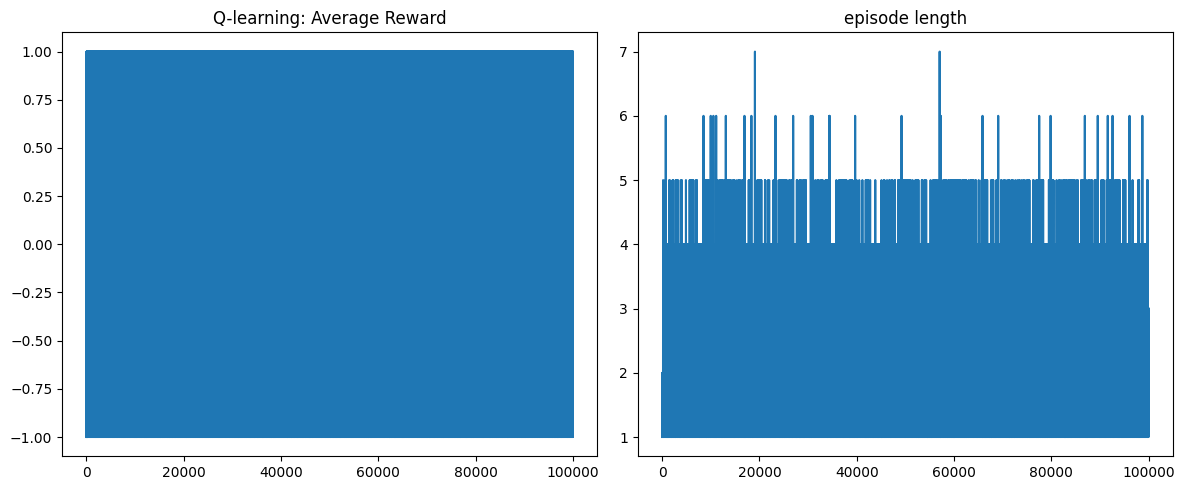

In [35]:

env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)
rewards, q_table, episodes = q_learning(env, 100_000, 0.1, 0.95, 0.1)

rewards_ma = est_moving_avg(np.array(env.return_queue),5000)
episode_ma = est_moving_avg(np.array(env.length_queue),5000)

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Q-learning: Average Reward")
axs[0].plot(list(range(len(np.array(env.return_queue)))),np.array(env.return_queue))

axs[1].set_title("episode length")
axs[1].plot(list(range(len(np.array(env.length_queue)))),np.array(env.length_queue))

plt.tight_layout()
plt.show()

We can see that it quickly becomes difficult to track various metrics and outputs + code get noisy/messy

If we apply a moving average outputs look more interpretable but code is hard to itterate

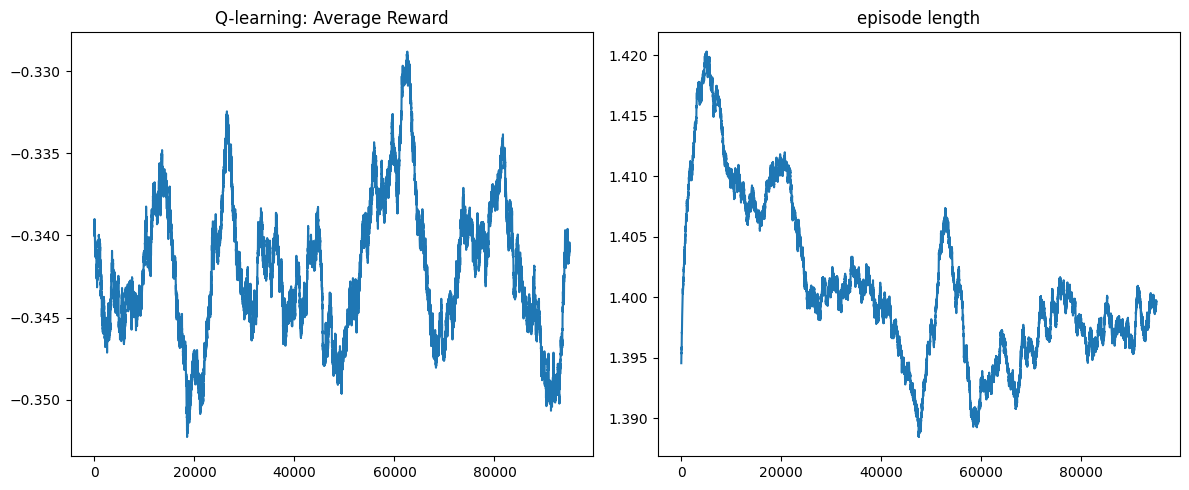

In [18]:
def est_moving_avg(in_arr: np.array, rolling_length=500,mode="valid"):
    '''
    uses convolution to shape a moving average of the metric that is easier to plot
    '''
    rescale = np.convolve(
        in_arr.flatten(), np.ones(rolling_length), mode=mode
    ) / rolling_length
    
    return rescale

rewards_ma = est_moving_avg(average_rewards,5000)
episode_ma = est_moving_avg(experiment_episodes,5000)
# error_ma = est_moving_avg(error,5000)

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].set_title("Q-learning: Average Reward")
axs[0].plot(list(range(len(rewards_ma))),rewards_ma)

axs[1].set_title("episode length")
axs[1].plot(list(range(len(episode_ma))),episode_ma)

# axs[2].set_title("Temporal diff error")
# axs[2].plot(list(range(len(error_ma))),error_ma)

plt.tight_layout()
plt.show()

## Improved coding practices and conventions for RL

The initial solution leaves a lot to be desired, now we can start talking about coding practices and hacks.
Let's start with the following:  

- using a DefaultDict for problems where we wish to record values against the state-action space in a table (e.g. Q-table)
- showing types for function inputs and outputs (Type Hinting)
- functions that do 1 thing
- using objects and classes

Why OOP?  
We consider using an "agent" object here because we are often tracking many fields or values pertaining to the agent and needlessly pass them around.  
Creating a type of q-learning agent we can inherit from basic agents and we can try to create an agent appropriate for any gym envirinment where a Q-table could be implemented.  

With an agent class we can also record fields while making sure the methods do only what they need to.

In [20]:
class agent:
    rewards = []
    errors = []
    episode = 0
    
    def update(self):
        pass

    def get_action(self):
        pass

    def anneal_epsilon(self, min_epsilon, max_epsilon, decay_rate=0.01):
        self.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * self.episode)

    def moving_average(self, x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    
    def plot(self):
        fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
        axs[0].set_title("Average Reward")
        axs[0].plot(list(range(len(self.moving_average(self.rewards,500)))),self.moving_average(self.rewards,500))

        axs[1].set_title("Temporal diff error")
        axs[1].plot(list(range(len(self.moving_average(self.errors,500)))),self.moving_average(self.errors,500))

        plt.tight_layout()
        plt.show()
        

And for the q-learning algorithm the following child class

In [31]:
class q_learnin_agent(agent):
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n))
        self.episode = 0

    def update(self, state: Tuple[int, int, bool], action: int, reward: int, next_state: Tuple[int, int, bool], done: bool)-> None:
        self.episode += 1
        
        if done:
            temporal_diff = self.alpha * (reward - self.q_table[state][action])
        else:
            temporal_diff = self.alpha * (reward + self.gamma * np.max(self.q_table[next_state]) - self.q_table[state][action])
        
        self.q_table[state][action] += temporal_diff
        self.errors.append(temporal_diff)
        self.anneal_epsilon(0.01, 1, 0.001)
        
    def get_action(self, state: Tuple[int, int, bool]) -> int:
        if np.random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])
        
    def get_q_table(self):
        return self.q_table

In [33]:
env = gym.make('Blackjack-v1')
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=num_episodes)
q_agent = q_learnin_agent(env, alpha=0.1, gamma=0.95, epsilon=0.1)
for _ in range(100_000):
    state, trunc = env.reset()
    done = False
    while not done:
        action = q_agent.get_action(state)
        next_state, reward, done, _, info = env.step(action)
        q_agent.update(state, action, reward, next_state, done)
        state = next_state
        q_agent.rewards.append(reward)


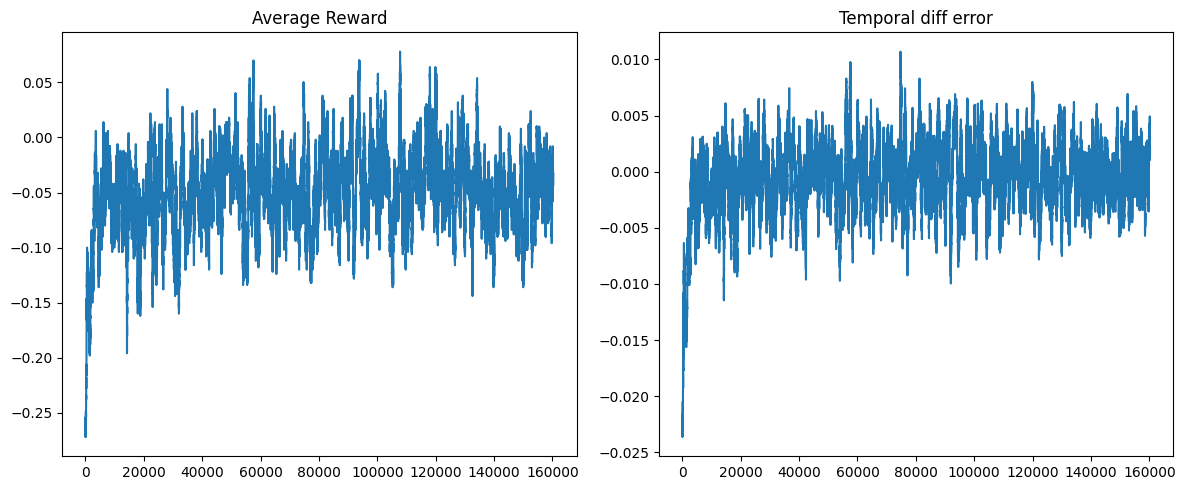

In [34]:
q_agent.plot()